In [9]:
#from notears.locally_connected import LocallyConnected
from lbfgsb_scipy import LBFGSBScipy
from trace_expm import trace_expm
import torch
import torch.nn as nn
import numpy as np
import math
from locally_connected import LocallyConnected

In [10]:
torch.set_default_dtype(torch.float64)

In [16]:
class NotearsMLP(nn.Module):
    def __init__(self, dims, bias=True):
        super(NotearsMLP, self).__init__()
        assert len(dims) >= 2
        assert dims[-1] == 1 # output dim of last layer must be 1
        d = dims[0]
        self.dims = dims
        # fc1: variable splitting for l1
        self.fc1_pos = nn.Linear(d, d * dims[1], bias=bias)
        self.fc1_neg = nn.Linear(d, d * dims[1], bias=bias)
        
        self.fc1_pos.weight.bounds = self._bounds()
        self.fc1_neg.weight.bounds = self._bounds()
        # fc2: local linear layers
        layers = []
        for l in range(len(dims) - 2):
            layers.append(LocallyConnected(d, dims[l + 1], dims[l + 2], bias=bias))
        self.fc2 = nn.ModuleList(layers)

    def _bounds(self):
        d = self.dims[0]
        bounds = []
        for j in range(d):
            for m in range(self.dims[1]):
                for i in range(d):
                    if i == j:
                        bound = (0, 0) # self loop not allowed
                    else:
                        bound = (0, None)
                    bounds.append(bound)
        return bounds

    def forward(self, x):  # [n, d] -> [n, d]
        x = self.fc1_pos(x) - self.fc1_neg(x)  # [n, d * m1] pass linear layer through input x
        #print(x.shape)
        x = x.view(-1, self.dims[0], self.dims[1])  # [n, d, m1]
        for fc in self.fc2:
            x = torch.sigmoid(x)  # [n, d, m1]
            x = fc(x)  # [n, d, m2]
            #print(x.shape)
        x = x.squeeze(dim=2)  # [n, d]
        return x

    def h_func(self):
        """Constrain 2-norm-squared of fc1 weights along m1 dim to be a DAG"""
        d = self.dims[0]
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j * m1, i]
        fc1_weight = fc1_weight.view(d, -1, d)  # [j, m1, i]
        A = torch.sum(fc1_weight * fc1_weight, dim=1).t()  # [i, j]
        h = trace_expm(A) - d  # (Zheng et al. 2018)
        # A different formulation, slightly faster at the cost of numerical stability
        # M = torch.eye(d) + A / d  # (Yu et al. 2019)
        # E = torch.matrix_power(M, d - 1)
        # h = (E.t() * M).sum() - d
        return h

    def l2_reg(self):
        """Take 2-norm-squared of all parameters"""
        reg = 0.
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j * m1, i]
        reg += torch.sum(fc1_weight ** 2)
        for fc in self.fc2:
            reg += torch.sum(fc.weight ** 2)
        return reg

    def fc1_l1_reg(self):
        """Take l1 norm of fc1 weight"""
        reg = torch.sum(self.fc1_pos.weight + self.fc1_neg.weight)
        return reg

    @torch.no_grad()
    def fc1_to_adj(self) -> np.ndarray:  # [j * m1, i] -> [i, j]
        """Get W from fc1 weights, take 2-norm over m1 dim"""
        d = self.dims[0]
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j * m1, i]
        fc1_weight = fc1_weight.view(d, -1, d)  # [j, m1, i]
        A = torch.sum(fc1_weight * fc1_weight, dim=1).t()  # [i, j]
        W = torch.sqrt(A)  # [i, j]
        W = W.cpu().detach().numpy()  # [i, j]
        return W


def squared_loss(output, target):
    n = target.shape[0]
    loss = 0.5 / n * torch.sum((output - target) ** 2)
    return loss


def dual_ascent_step(model, X, lambda1, lambda2, rho, alpha, h, rho_max):
    """Perform one step of dual ascent in augmented Lagrangian."""
    h_new = None
    optimizer = LBFGSBScipy(model.parameters())
    for idx, param in enumerate(model.parameters()):
        print('layer:',idx,'shape:',param.shape)
    #print(model.parameters().shape)
    #print("model.parameters(): ", model.parameters().data())
    X_torch = torch.from_numpy(X)
    while rho < rho_max:
        print("rho: ", rho)
        def closure():
            optimizer.zero_grad()
            X_hat = model(X_torch)
            loss = squared_loss(X_hat, X_torch)
            h_val = model.h_func()
            print("h_val: ", h_val)
            penalty = 0.5 * rho * h_val * h_val + alpha * h_val
            l2_reg = 0.5 * lambda2 * model.l2_reg()
            l1_reg = lambda1 * model.fc1_l1_reg()
            primal_obj = loss + penalty + l2_reg + l1_reg
            primal_obj.backward()
            print('squared loss:', loss.item())
            print('loss:', primal_obj.item())
            print('penalty:', penalty.item())
            return primal_obj
        optimizer.step(closure)  # NOTE: updates model in-place
        with torch.no_grad():
            h_new = model.h_func().item()
            print("h_new: ", h_new)
        if h_new > 0.25 * h:
            rho *= 10
        else:
            break
    alpha += rho * h_new
    return rho, alpha, h_new


def notears_nonlinear(model: nn.Module,
                      X: np.ndarray,
                      lambda1: float = 0.,
                      lambda2: float = 0.,
                      max_iter: int = 100,
                      h_tol: float = 1e-8,
                      rho_max: float = 1e+16,
                      w_threshold: float = 0.3):
    rho, alpha, h = 1.0, 0.0, np.inf
    for _ in range(max_iter):
        rho, alpha, h = dual_ascent_step(model, X, lambda1, lambda2,
                                         rho, alpha, h, rho_max)
        if h <= h_tol or rho >= rho_max:
            break
    W_est = model.fc1_to_adj()
    print(W_est)
    W_est[np.abs(W_est) < w_threshold] = 0
    W_est[np.abs(W_est) >= w_threshold] = 1
    X_torch = torch.from_numpy(X)
    output = model.forward(X_torch)
    return W_est, output

In [35]:
torch.set_default_dtype(torch.double)
np.set_printoptions(precision=3)

import utils as ut
ut.set_random_seed(123)

n, d, s0, graph_type, sem_type = 100, 4, 3, 'ER', 'mim'
B_true = ut.simulate_dag(d, s0, graph_type)
#np.savetxt('W_true.csv', B_true, delimiter=',')
print("W_true: ", B_true)

X = ut.simulate_nonlinear_sem(B_true, n, sem_type)
#np.savetxt('X.csv', X, delimiter=',')
print("X.dtype: ", X.dtype)

model = NotearsMLP(dims=[d, 10, 1], bias=True)
W_est = notears_nonlinear(model, X, lambda1=0.01, lambda2=0.01)
#np.savetxt('W_est.csv', W_est, delimiter=',')
print("W_est", W_est)

W_true:  [[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]
X.dtype:  float64
layer: 0 shape: torch.Size([40, 4])
layer: 1 shape: torch.Size([40])
layer: 2 shape: torch.Size([40, 4])
layer: 3 shape: torch.Size([40])
layer: 4 shape: torch.Size([4, 10, 1])
layer: 5 shape: torch.Size([4, 1])
layer: 0 shape: torch.Size([40, 4])
layer: 1 shape: torch.Size([40])
layer: 2 shape: torch.Size([40, 4])
layer: 3 shape: torch.Size([40])
layer: 4 shape: torch.Size([4, 10, 1])
layer: 5 shape: torch.Size([4, 1])
layer: 0 shape: torch.Size([40, 4])
layer: 1 shape: torch.Size([40])
layer: 2 shape: torch.Size([40, 4])
layer: 3 shape: torch.Size([40])
layer: 4 shape: torch.Size([4, 10, 1])
layer: 5 shape: torch.Size([4, 1])
layer: 0 shape: torch.Size([40, 4])
layer: 1 shape: torch.Size([40])
layer: 2 shape: torch.Size([40, 4])
layer: 3 shape: torch.Size([40])
layer: 4 shape: torch.Size([4, 10, 1])
layer: 5 shape: torch.Size([4, 1])
layer: 0 shape: torch.Size([40, 4])
layer: 1 shape: torch.Size([

In [27]:
np.random.seed(2)
x = np.random.normal(10,2, 100)

np.random.seed(24)
l = np.random.normal(0,1, 100) 


np.random.seed(25)
b = np.random.normal(0,1, 100) 


y = [8*x + l for x, l in zip(x, l)]
z = [3*x + b for x, b in zip(x, b)]

X = np.column_stack((x, y, z))
n = X.shape[0]
d = X.shape[1]

print(n)
print(d)

model = NotearsMLP(dims=[d, 10, 1], bias=True)
W_est = notears_nonlinear(model, X, lambda1=0.01, lambda2=0.01)
# worked

100
3
model.parameters():  <generator object Module.parameters at 0x00000183D91CB3E0>
model.parameters():  <generator object Module.parameters at 0x00000183D91CB3E0>
model.parameters():  <generator object Module.parameters at 0x00000183D91CB3E0>
model.parameters():  <generator object Module.parameters at 0x00000183D91CB3E0>
model.parameters():  <generator object Module.parameters at 0x00000183D91CB3E0>
model.parameters():  <generator object Module.parameters at 0x00000183D91CB3E0>
model.parameters():  <generator object Module.parameters at 0x00000183D91CB3E0>
model.parameters():  <generator object Module.parameters at 0x00000183D91CB3E0>
model.parameters():  <generator object Module.parameters at 0x00000183D91CB3E0>
model.parameters():  <generator object Module.parameters at 0x00000183D91CB3E0>
[[0.000e+00 3.445e+00 1.147e+00]
 [1.803e-05 0.000e+00 4.444e-02]
 [5.936e-05 4.221e-04 0.000e+00]]


In [17]:
np.random.seed(2)
x = np.random.normal(10,2, 100)

np.random.seed(24)
l = np.random.normal(0,1, 100) 

# marker
np.random.seed(25)
b = np.random.normal(0,1, 100) 


y = [x**2 + l for x, l in zip(x, l)]

X = np.column_stack((x, y))
#X_torch = torch.from_numpy(X)

n = X.shape[0]
d = X.shape[1]

print(n)
print(d)

model = NotearsMLP(dims=[d, 10, 1], bias=True)
W_est, output = notears_nonlinear(model, X, lambda1=0.01, lambda2=0.01)
print(W_est)

100
2
layer: 0 shape: torch.Size([20, 2])
layer: 1 shape: torch.Size([20])
layer: 2 shape: torch.Size([20, 2])
layer: 3 shape: torch.Size([20])
layer: 4 shape: torch.Size([2, 10, 1])
layer: 5 shape: torch.Size([2, 1])
rho:  1.0
h_val:  tensor(1.4787, grad_fn=<SubBackward0>)
squared loss: 5905.827733332536
loss: 5907.031154997175
penalty: 1.0932550882931038
h_val:  tensor(2.3852, grad_fn=<SubBackward0>)
squared loss: 5707.517100784814
loss: 5710.493434007071
penalty: 2.8445114420423203
h_val:  tensor(73.0420, grad_fn=<SubBackward0>)
squared loss: 5251.345326810472
loss: 7919.171499616669
penalty: 2667.569940455434
h_val:  tensor(6.3179, grad_fn=<SubBackward0>)
squared loss: 5532.759046691448
loss: 5552.8816584162905
penalty: 19.957633440263237
h_val:  tensor(42.1343, grad_fn=<SubBackward0>)
squared loss: 5295.318429855154
loss: 6183.203041423506
penalty: 887.6477375642581
h_val:  tensor(10.5317, grad_fn=<SubBackward0>)
squared loss: 5459.23516071929
loss: 5514.8772519515205
penalty: 55.

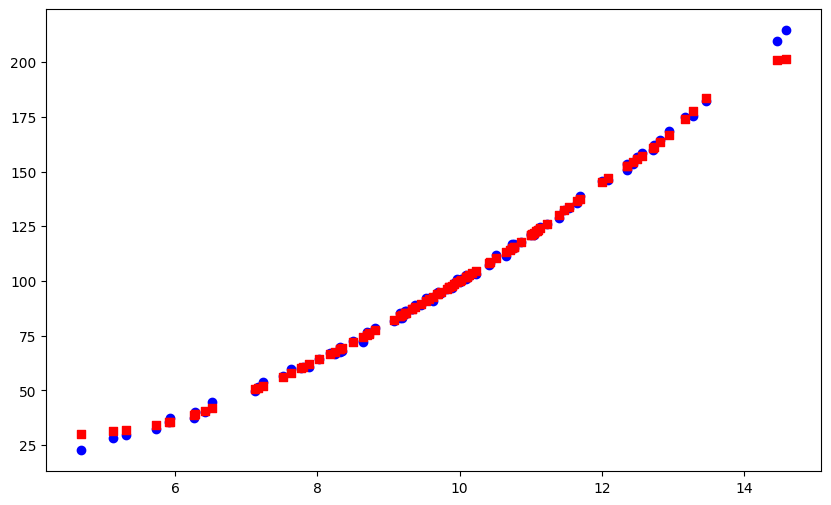

In [8]:
import matplotlib.pyplot as plt

y_hat = output[:, 1].detach().numpy()
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(x, y, label='y1', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(x, y_hat, label='y2', color='red', marker='s') 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


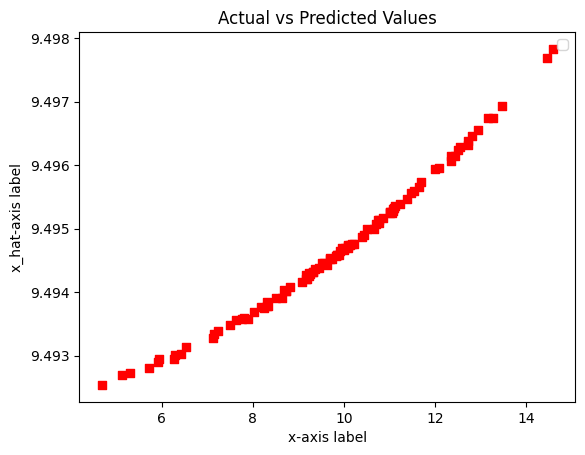

In [19]:
x_hat = output[:, 0].detach().numpy()

plt.scatter(x, x_hat, color='red', marker='s')  # Plot x vs. y_hat

plt.legend()  # Show legend to differentiate between actual and predicted values
plt.title('Actual vs Predicted Values')  # Optional: Adds a title to the plot
plt.xlabel('x-axis label')  # Optional: Label for the x-axis
plt.ylabel('x_hat-axis label')  # Optional: Label for the y-axis
plt.show()